In [3]:
cd /mnt/Data/Workspaces/Eclipse/dataAnalysis/Sleep-current/src/

/mnt/Data/Workspaces/Eclipse/dataAnalysis/Sleep-current/src


In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import seaborn as sns
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as pl
import pickle as pkl
import Recordings
import signale
import extras.trees
import os
import trajectory, custom_plot,extras
import scipy.signal as scsig
import scipy
import timeit
import spectrum as spc
import pandas as pd
import statsmodels.api as sm

/home/chenani/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:1318: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [5]:
colors = ['#0000FF','#FF0000','#008000','#BF00BF','#000000','#00FFFF','#EE82EE',
          '#808000','#800080','#FF6347','#FFFF00','#9ACD32','#4B0082',
          '#FFFACD','#C0C0C0','#A0522D','#FA8072','#FFEFD5','#E6E6FA',
          '#F1FAC1','#C5C5C5','#FF00FF','#A152ED','#FADD72','#F0EFD0','#EEE6FF',
          '#01FAC1','#F5F5F5','#A152FF','#FAFD72','#F0EFDF','#EEEFFF',
          '#F1FA99','#C9C9C9','#A152DD','#FA5572','#FFFFD0','#EDD6FF']

clrst = ['#6CCECB','#F9E559','#EF7126','#8EDC9D','#473E3F',
         '#336699','#E39910','#9C691E','#FA220A','#168282','#02111A','#218C8D','#A37B45','#86942A','#507642']

fontsize=14.0
markersize = 6

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.markersize'] = markersize
mpl.rcParams['font.size'] = fontsize
mpl.rcParams['xtick.direction'] = 'out'
mpl.rcParams['ytick.direction'] = 'out'


grey = np.ones(3)*.25
transred = '#FFA1A1'

In [6]:
def subsequence(sub,ref):
    '''
    A function to determine the number of specefic sequence repeated within a larger sequence.
    
    Parameters:
    sub:
    ref:
    
    
    Returns:
    idx : This an array containing the index of elements of sub in the ref! if idx is stricktly increasing the sequence sub
    is replayed whithin sequence ref!
    '''
    ref = np.array(ref)
    idx = np.array([])
    for ii in range(len(sub)):
        index = np.where(ref == sub[ii])[0]
        if index.size:
            idx = np.append(idx,index)
    idx = np.int0(idx)
    if idx.size:
        return idx, True
    else: 
        return [] , False
    
def sequencer(arr,method = 'median'):
    '''
    This function sequences the given array(with possible repeated elements) into an array of distinct elements! Considering either 
    first or the midian position of repeated elements.
    '''
    arr = np.array(arr)
    idx_seq = np.array([])
    if method == 'median':
        for item in set(arr):
            idx_seq = np.append(idx_seq,median(np.where(arr == item)[0]))
        idx_seq.sort()
    if method == 'first':
        for item in set(arr):
            idx_seq = np.append(idx_seq,np.where(arr == item)[0][0])
        idx_seq.sort()

    return arr[np.int0(idx_seq)]

def median(arr):
    '''
    mY median... ;)
    '''
    arr = np.array(arr)
    if np.mod(arr.size,2) == 0 :
        return arr[arr.size / 2 - 1]
    else: 
        return arr[arr.size / 2 ]

def locate(pattern, root=os.curdir):
    '''Locate all files matching supplied filename pattern in and below
        supplied root directory.
    '''
    for path, dirs, files in os.walk(os.path.abspath(root)):
        for filename in fnmatch.filter(files, pattern):
            yield [path,filename]
            
def next_permutation(arr):
    '''
    
        Computes the next lexicographical permutation of the specified list in place,
     returning whether a next permutation existed. (Returns False when the argument
     is already the last possible permutation.)
    
    
         Example:
            arr = [0, 1, 0]
            next_permutation(arr)  (returns True)
            arr has been modified to be [1, 0, 0]
    Reference:
    -----------
    Nayuki Minase, 2014. Public domain.
    http://nayuki.eigenstate.org/page/next-lexicographical-permutation-algorithm
            '''
    
    i = len(arr) - 1
    while i > 0 and arr[i - 1] >= arr[i]:
        i -= 1
    if i <= 0:
        return False
    
    # Find successor to pivot
    j = len(arr) - 1
    while arr[j] <= arr[i - 1]:
        j -= 1
    arr[i - 1], arr[j] = arr[j], arr[i - 1]
    
    # Reverse suffix
    arr[i : ] = arr[len(arr) - 1 : i - 1 : -1]
    return True

def number_of_permutations(arr):
    Cnk = [] #keep the combinations!
    s = 0    # sum of repitiotions of elements in arr!
    arrcp = np.array(arr).copy()
    arrcp.sort()
    for item in set(arrcp):
        reps = np.where(arrcp == item)[0].size
        Cnk.append(comb(arrcp.size - s,reps,True))
        s += reps
    return np.prod(np.array(Cnk))
def all_permutations(arr):
    '''
    produces all possible permutations of a given array using lexographical ordering.
    Sequence the arrays and returns the weights of all possible sequences!
    This version is fast but memory consuming, better for the short arrays!
    written by A. Chenani Sep. 2014
    '''
    sqStack = []
    weightsStack = []
    for item in arr:
        item.sort()
        arr_seqz = [sequencer(item)]
        #####Cunstructing sequence set
        start =  timeit.default_timer()
        
        arr_seqz_set = np.array([])
        sample_seq = arr_seqz[0].copy()
        sample_seq.sort()
        arr_seqz_set = np.append(arr_seqz_set,sample_seq)
        while next_permutation(sample_seq):
            arr_seqz_set = np.append(arr_seqz_set,sample_seq)
        arr_seqz_set = arr_seqz_set.reshape(np.math.factorial(sample_seq.size),arr_seqz[0].size)
        
        stop = timeit.default_timer()
        #print 'part one --> %f' %(stop - start)
        
        
        #####creating MUA permutation list!
        start =  timeit.default_timer()
        
        while next_permutation(item):
            arr_seqz.append(sequencer(item))
        arr_seqz = np.array(arr_seqz) #This contains all sequences coming from permutations of an specific MUA!
       
        stop = timeit.default_timer()
        #print 'part two --> %f' %(stop - start)
        
        #####Calculating the wights of all possible sequences
        start =  timeit.default_timer()
        weights = []
        for item in arr_seqz_set:
            selection = arr_seqz[np.where(arr_seqz[:,0]==item[0])[0]]
            for ii in range(1,arr_seqz_set.shape[1]):
                selection = selection[np.where(selection[:,ii]==item[ii])[0]]
            weights.append(selection.size/float(arr_seqz.size))
        weightsStack.append(np.array(weights))
        sqStack.append(arr_seqz_set)
        
        stop = timeit.default_timer()
        #print 'part three --> %f' %(stop - start)
    return sqStack,weightsStack

In [7]:
###################################################### Parameters
expType = 'real'
prefix = 'pl'
suffix = ''
noSpeck = False
onlyRunning = True
showHeadDir = False
saveFigs = True
useRecommended = False
TTName = '.t'

# initialize in order to make them available globally
spikes=[]
ID=-1
stList=signale.spikezugList(t_start=None, t_stop=None, dims=[2])
traj = None
eventData = None

cwd=os.getcwd()


###################################################### functions

def getTData(folderName):
    global spikes, ID, traj, eventData

    if os.path.isdir(folderName):
        dirList=os.listdir(folderName)
        os.chdir(folderName)
    else:
        dirList = [folderName]

    for item in sorted(dirList):
        if os.path.isfile(item):
            if (TTName.__class__ == list and item in TTName) or\
                    (TTName.__class__ == str and item.endswith(suffix+'.t') and item.startswith(prefix)):
                print 'loading', item , 'from folder: '+folderName
                spikes = signale.load_tFile(item, showHeader=False)
                ID += 1
                stList.__setitem__(ID, spikes)
                stList.addTags(ID, file=item, dir=folderName)
            # real
            elif expType == 'real':
                if item.endswith('.nvt'):   ## or item.endswith('2.ncs'):
                    print 'loading', item , 'from folder: '+folderName
                    loadedSomething = True
                    traj = trajectory.load_nvtFile(item, 'linearMaze', showHeader=False)
                    HDtraj = traj[1]        # head direction
                    traj = traj[0]          # trajectory
            # vr
            elif expType == 'vr':
                if item.endswith('.nev'):
                    print 'loading', item , 'from folder: '+folderName
                    eventData = signale.load_nevFile(item, showHeader=False)
                elif item.endswith('.traj') and item.find('position')+1\
                 and not item.find('collisions_position')+1 and not item.find('rewardsVisited_position')+1:
                    print 'loading', item , 'from folder: '+folderName
                    if item.startswith('linearMaze'):
                        traj = trajectory.load_trajectory(item, showHeader=False)
                    else:
                        traj = trajectory.load_trajectory(item, showHeader=False)
        elif os.path.isdir(item):
            getData(item)
    os.chdir('..')
# parameters
lang='e'
color1='g'
color2='k'
showFigs=True
saveFigs=True
saveAna=True
onlyWithTTData=False
useRecommended = False
excludeCSCs = []


#################Make a help flag for the script!!!
#
####################################################


# initialize in order to make them globally available
cscID = -1
cscList = signale.NeuralynxCSCList()

loadedSomething = False
cwd = os.getcwd()



if useRecommended:
    if os.path.isfile(folderName+'metadata.dat'):
        print 'Loading metadata:'
        metadata = signale._read_metadata(folderName+'metadata.dat', showHeader=True)
        if metadata.has_key('excludeCSCs'):
            exec 'excludeCSCs =' + metadata['excludeCSCs']
            print 'Excluding csc data listed in metadata.dat! CSCs:', excludeCSCs
        print
    else:
        print 'NOTE: There is no metadata.dat. Proceeding without instead.'



def getData(folderName):
    global cscID, cscList, loadedSomething

    if os.path.isdir(folderName):
        dirList=os.listdir(folderName)
        os.chdir(folderName)
    else:
        dirList = [folderName]

    if onlyWithTTData and not any([item.endswith('.t') for item in dirList]):
        os.chdir(cwd)
        sys.exit('The folders do not contain tetrode data (t files)! Therefore skipping folder!')
    for item in sorted(dirList):
        if os.path.isfile(item):
            if item.endswith('.ncs') and not any([item.find(str(s))+1 for s in excludeCSCs]):# or item.endswith('2.ncs'):
                print 'loading Neuralynx data', item , 'from folder: '+folderName
                loadedSomething = True
                csc = signale.load_ncsFile(item, showHeader=False)
                cscID += 1
                cscList.append(cscID, csc)
                cscList.addTags(cscID, file=item, dir=folderName)
            elif item.endswith('.raw'):# or item.endswith('2.ncs'):
                print 'loading RAW data', item , 'from folder: '+folderName
                loadedSomething = True
                cscList = []
                cscList = signale.load_rawFile(item, exclude=excludeCSCs, showHeader=False)
        #elif os.path.isdir(item):
        #    getData(item)
    os.chdir('..')

In [8]:
experimentFolder = '/mnt/Data/ephysdata/Gerbils/G5/'
leftFields = pkl.load(open('/mnt/Data/ephysdata/Gerbils/G5/leftPlaceOrder.arr'))
rightFields = pkl.load(open('/mnt/Data/ephysdata/Gerbils/G5/rightPlaceOrder.arr'))
placeCell_ids = np.union1d(leftFields,rightFields)

In [7]:
getData(experimentFolder)
getTData(experimentFolder)
ch0 = cscList[0]
sleepSpk = stList.time_slice(2102345.80,stList.t_stop)
sleepSpk.timeAxis = ch0.timeAxis.copy()
#for train in sleepSpk:
#    train.convolveSpikes(numpy.array([1]))
rec = Recordings.ephys(sleepSpk,cscList)

#rec.spikes.sumConvolvedSpikeTrains()
rec.coincidence('s')
rec.MUA()
rec.sequencing()

loading Neuralynx data CSC1.ncs from folder: /mnt/Data/ephysdata/Gerbils/G5/
TimeAxis calculation took 0.0330920219421 seconds
loading VT1.nvt from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT1_01.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT1_05.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT1_10.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT1_13.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT1_15.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT2_02.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT3_02.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT3_04.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT3_06.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT3_07.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT4_05.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
loading pl_TT4_07.t from folder: /mnt/Data/ephysdata/Gerbils/G5/
Using surrogate data...
There is

In [8]:
mua = [] 
for jj in range(len(rec.MultiUnitActivity)):
    mua.append(rec.MultiUnitActivity[jj][:,0])
mua = np.array(mua)

ss = np.array([item.size for item in mua])
examples = np.where(ss > 13)[0]
cellTags = [np.int0(rec.sequence_median[item][:,0]) for item in examples]
print cellTags
print examples

[array([10,  0,  5,  7,  8]), array([ 0, 10,  8,  2,  3, 11,  9]), array([ 7,  5,  1,  6,  8,  2, 11, 10])]
[110 186 222]


(<matplotlib.figure.Figure at 0x7faccc3c7e90>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7faca07c8810>)

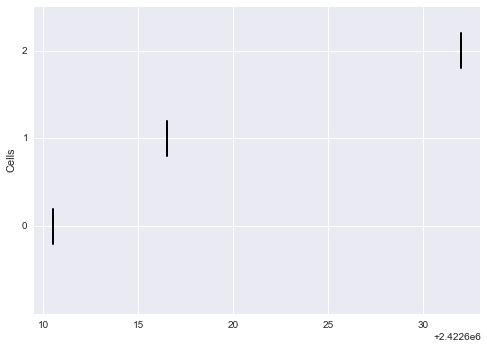

In [9]:
rec.sequence_raster(135)

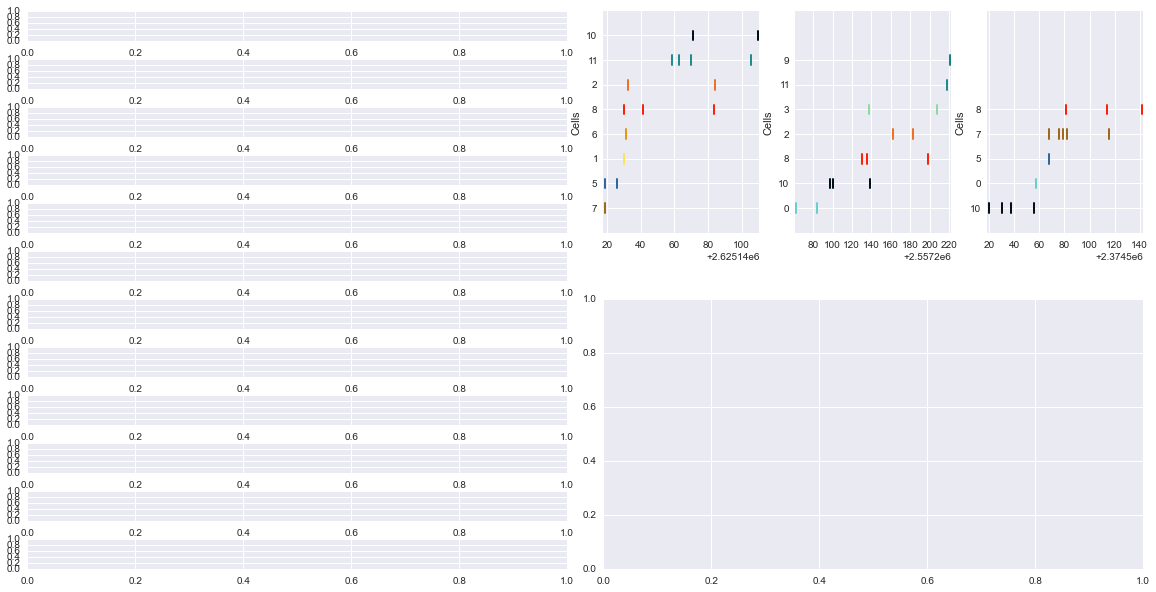

In [10]:
n = 12
plarr = []
sqarr = []
fgx = pl.figure(figsize = [20,10]);
for item in range(n):
    plarr.append(pl.subplot2grid((n,n),(item,0),colspan= n /2));
for item in range(3):
    sqarr.append(pl.subplot2grid((n,n),(0,6+2*item),rowspan=5,colspan=2))
dist = pl.subplot2grid((n,n),(6,6),rowspan=6,colspan=6)

rec.sequence_raster(222,ax1=sqarr[0],ClrMap =clrst)
rec.sequence_raster(186,ax1=sqarr[1],ClrMap = clrst );
rec.sequence_raster(110,ax1=sqarr[2],ClrMap = clrst );
sqarr[0].set_ylim([-1,8]);
sqarr[0].set_yticklabels(cellTags[2]);
sqarr[1].set_ylim([-1,8]);
sqarr[1].set_yticklabels(cellTags[1]);
sqarr[2].set_ylim([-1,8]);
sqarr[2].set_yticklabels(cellTags[0]);
fgx.subplots_adjust(wspace = 0.6,hspace=0.6)

In [11]:
stList
stList._spikezugList__recalc_startstop()
stList.changeTimeUnit('s')

traj.threshspeed = 1.4# minimum speed for trajectory as running (m/s)

traj.getTrajDimensions()
traj.getRunningTraj()    # remove from traj.times and
                         # traj.places, times at which animal didn't run <threshspeed

Tracklist = stList.time_slice(traj.t_start,traj.t_stop)
for zaehler, st in enumerate(Tracklist):
    st.traj = traj
    st.getSpikePlaces();
    st.getRunningSpikes();
for zaehler, st in enumerate(Tracklist):
    st.traj.getLeftAndRightwardRuns(onlyRunning=onlyRunning)
    st.getLeftAndRightwardSpikes(onlyRunning=onlyRunning)

calculating trajectory with running speed >= 1.4
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.
NOTE: Using linear interpolation to get the places.


In [12]:
bins = np.linspace(0,2,80)
height = 0
idxL = leftFields
idxR = rightFields
peaksR = []
peaksL = []
hstSmoothR = []
hstSmoothL = []
#fR,axarrR = pl.subplots(len(idxR),sharex=True,sharey=True)
#fL,axarrL = pl.subplots(len(idxL),sharex=True,sharey=True)

for ii in range(len(idxR)):
    Tracklist[idxR[ii]].getRunningSpikes(1.2)
    hstR = np.histogram(np.intersect1d(Tracklist[idxR[ii]].run_spikePlaces[:,0],Tracklist[idxR[ii]].rechts_spikePlaces[:,0]),bins)
    hstL = np.histogram(np.intersect1d(Tracklist[idxR[ii]].run_spikePlaces[:,0],Tracklist[idxR[ii]].links_spikePlaces[:,0]),bins)
    hstSmoothR.append(np.convolve(hstR[0],scsig.gaussian(20,4),'same'))
    hstSmoothL.append(np.convolve(hstL[0],scsig.gaussian(20,4),'same'))
    hstSmoothR[-1] /= float(hstSmoothR[-1].max())
    hstSmoothL[-1] /= float(hstSmoothL[-1].max())
    peaksR.append(bins[hstSmoothR[-1].argmax()])
    peaksL.append(bins[hstSmoothL[-1].argmax()])

peaksL = np.array(peaksL)
peaksR = np.array(peaksR)
plidxR = peaksR.argsort()
plidxL = peaksL.argsort()
placeSortedR = idxR[plidxR]
placeSortedL = idxR[plidxL]
for ii in range(placeSortedR.size):
    plarr[ii].plot(bins[:-1],hstSmoothR[plidxR[ii]] + height,color=clrst[placeSortedR[ii]])
    plarr[ii].fill_between(bins[:-1],hstSmoothR[plidxR[ii]] + height,facecolor=grey,alpha=0.2)
    #axarrR[ii].plot(bins[:-1],hstSmoothL[plidxR[ii]] + height,color=colors[plidxR[ii]],dashes=(5,10))
    plarr[ii].axvline(bins[hstSmoothR[plidxR[ii]].argmax()],0.85,0.95,color=clrst[placeSortedR[ii]])
    #axarr[ii].axvline(bins[hstSmoothL[plidxL[ii]].argmax()],0.79,0.95,color=colors[plidxL[ii]])
    plarr[ii].set_ylabel(placeSortedR[ii])#spk.tags[idx[ii]]['file'][2:6])
    height += 0.001
    pl.setp(plarr[ii].get_yticklabels(), visible=False)
    #plarr[0].set_title('Rightward Fields')
###############################LEFTWARDS FIELDS!
############################################################################
peaksR = []
peaksL = []
hstSmoothR = []
hstSmoothL = []
for ii in range(len(idxL)):
    Tracklist[idxL[ii]].getRunningSpikes(1.2)
    hstR = np.histogram(np.intersect1d(Tracklist[idxL[ii]].run_spikePlaces[:,0],Tracklist[idxL[ii]].rechts_spikePlaces[:,0]),bins)
    hstL = np.histogram(np.intersect1d(Tracklist[idxL[ii]].run_spikePlaces[:,0],Tracklist[idxL[ii]].links_spikePlaces[:,0]),bins)
    hstSmoothR.append(np.convolve(hstR[0],scsig.gaussian(20,4),'same'))
    hstSmoothL.append(np.convolve(hstL[0],scsig.gaussian(20,4),'same'))
    hstSmoothR[-1] /= float(hstSmoothR[-1].max())
    hstSmoothL[-1] /= float(hstSmoothL[-1].max())
    #peaksR.append(bins[hstSmoothR[-1].argmax()])
    peaksL.append(bins[hstSmoothL[-1].argmax()])

peaksL = np.array(peaksL)
#peaksR = np.array(peaksR)
#plidxR = peaksR.argsort()
plidxL = peaksL.argsort()
#placeSortedR = idxL[plidxR]
placeSortedL = idxL[plidxL]
for ii in range(placeSortedL.size):
    iii = placeSortedL.size - ii -1 #Just to reverse the plotting order...
    plarr[iii+6].plot(bins[:-1],hstSmoothL[plidxL[ii]] + height,color=clrst[placeSortedL[ii]])
    plarr[iii+6].fill_between(bins[:-1],hstSmoothL[plidxL[ii]] + height,facecolor=grey,alpha=0.2)
    #axarrL[ii].plot(bins[:-1],hstSmoothR[plidxL[ii]] + height,color=colors[plidxL[ii]],dashes=(5,10))
    plarr[iii+6].axvline(bins[hstSmoothL[plidxL[ii]].argmax()],0.85,0.95,color=clrst[placeSortedL[ii]])
    #axarr[ii].axvline(bins[hstSmoothL[plidxL[ii]].argmax()],0.79,0.95,color=colors[plidxL[ii]])
    plarr[iii+6].set_ylabel(placeSortedL[ii])#spk.tags[idx[ii]]['file'][2:6])
    height += 0.0005
    pl.setp(plarr[iii+6].get_yticklabels(), visible=False)
#plarr[6].set_title('Leftward Fields')
#fL.savefig(experimentFolder+'/plots/leftFields.pdf',format='pdf')
#fR.savefig(experimentFolder+'/plots/rightFields.pdf',format='pdf')

NOTE: Reset threshspeed from 1.4 to 1.2 m/s
NOTE: Now calculating running traj > 1.2 m/s
calculating trajectory with running speed >= 1.2


In [13]:
plSeqz = []
plSeqz_idx = []
for ii,item in enumerate(mua):
    sqz = sequencer(item)
    if sqz.size > 1:
        plSeqz.append(sqz)
        plSeqz_idx.append(ii)
    else:
        plSeqz.append(np.arange(200,210))
        plSeqz_idx.append(-1)
plSeqz_idx = np.array(plSeqz_idx)
plSeqz = np.array(plSeqz)

In [14]:
PLrankCorrLPost = []
for lst in plSeqz:
    #print lst
    if subsequence(lst,leftFields)[1] and subsequence(lst,leftFields)[0].size > 3:
    #if subsequence(lst,leftFields)[1] and subsequence(lst,leftFields)[0].size > 2:
        corrPL =  scipy.stats.pearsonr(subsequence(lst,leftFields)[0],sorted(subsequence(lst,leftFields)[0]))
        PLrankCorrLPost.append(corrPL)
#print PLrankCorrLPost
PLrankCorrRPost = []
for lst in plSeqz:
    #print lst
    if subsequence(lst,rightFields)[1] and subsequence(lst,rightFields)[0].size > 3:
        corrPR =  scipy.stats.pearsonr(subsequence(lst,rightFields)[0],sorted(subsequence(lst,rightFields)[0]))
        PLrankCorrRPost.append(corrPR)

In [15]:
shuf6 = all_permutations([range(1,7)])[0][0]
shuf5 = all_permutations([range(1,6)])[0][0]
shuf4 = all_permutations([range(1,5)])[0][0]
shuf3 = all_permutations([range(1,4)])[0][0]

crr = []
shuf = [shuf4,shuf5]
for item in shuf:
    for jtem in item:
        corrPL =  scipy.stats.pearsonr(jtem,sorted(jtem))[0]
        crr.append(corrPL)

hst,bins = np.histogram(crr,21)
hstL,bins = np.histogram(PLrankCorrLPost,bins)
hstR,bins = np.histogram(PLrankCorrRPost,bins)
HST = hstL+hstR

dist.bar(bins[:-1],np.float128(hst)/hst.sum(),width=0.03);
dist.bar(bins[:-1]+0.03,np.float128(HST)/HST.sum(),width=0.03,color='g');
dist.legend(['Shuffeled','Replays'],loc='upper left');

In [16]:
for ax in plarr[:-1]:
    #custom_plot.allOff(ax)
    ax.set_yticks([])
    ax.set_xticklabels('',visible = False)
    ax.set_yticklabels('',visible = False)
    ax.xaxis.tick_bottom()
    ax.tick_params( direction='in')
for ax in sqarr:
    ax.xaxis.tick_bottom()

dist.set_yticklabels('',visible = False)
dist.xaxis.tick_bottom()
dist.set_xlabel('Correlation')
sqarr[1].set_ylabel('',visible=False)
sqarr[2].set_ylabel('',visible=False)
sqarr[2].set_xticklabels(['','0','','','','','','120'])
sqarr[1].set_xticklabels(['','0','','','','','','','140'])
sqarr[0].set_xticklabels(['','0','','','','80'])

plarr[-1].set_yticks([])
plarr[-1].set_xlabel('Position(m)')
plarr[-1].xaxis.tick_bottom()
plarr[-1].tick_params( direction='in')

sqarr[1].set_xlabel('Time(ms)')

sqarr[0].yaxis.set_label_coords(-0.1, 0.5)
plarr[0].set_xlabel('Right Fields')
plarr[0].xaxis.set_label_coords(0.5, 1.5)
plarr[6].set_xlabel('Left Fields')
plarr[6].xaxis.set_label_coords(0.5, 1.44)
fgx.text(0.1, 0.52,'Cells',rotation = 'vertical');


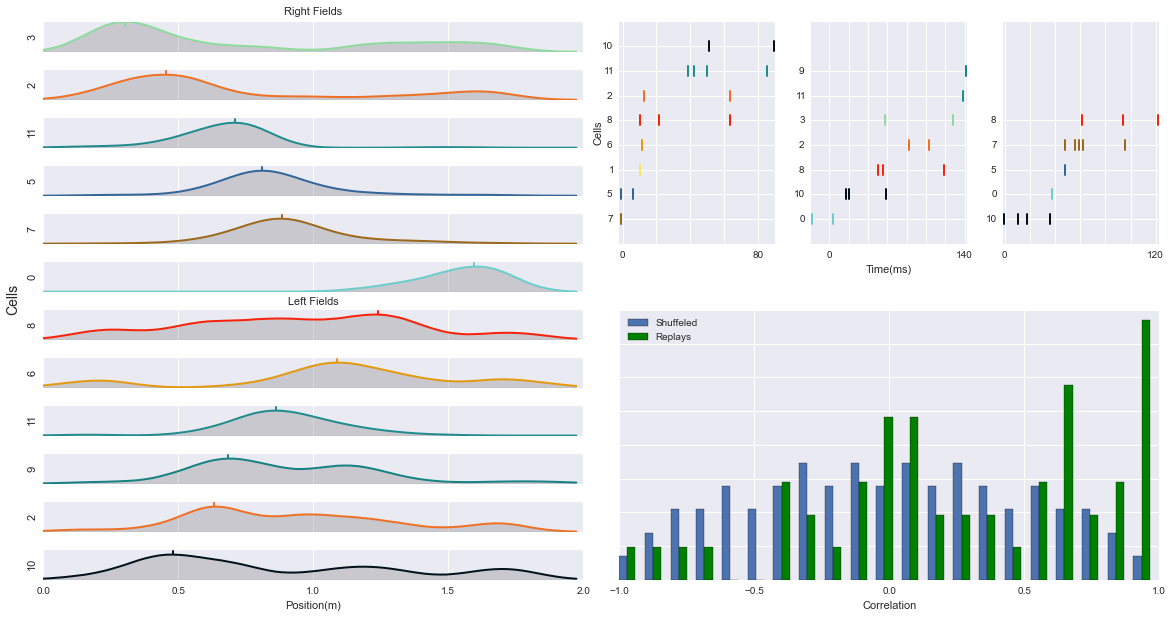

In [17]:
fgx

In [18]:
fgx.savefig('/home/chenani/Pictures/BCCN_Report/fig1.pdf',format='pdf')

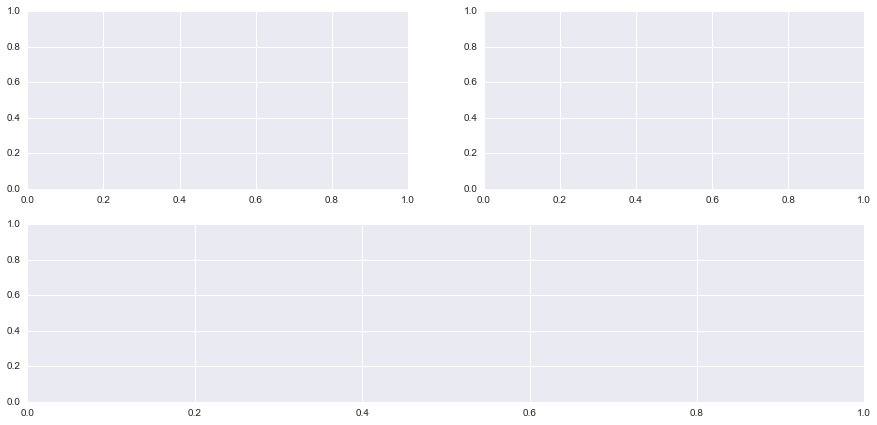

In [19]:
fig = pl.figure(figsize=[15,7]);
ax1 = pl.subplot2grid((2,2),(0,0))
ax2 = pl.subplot2grid((2,2),(0,1))
ax3 = pl.subplot2grid((2,2),(1,0),colspan=2)

In [20]:
ch0.ripple_recorder()

Signal is not filtered yet!
 Filtering the signal with the default values...
Hilbert transform is not calculated!
 Calculating Hilbert transform of the signal...
SWS and REM signals are not trimmed yet!
 Trimming SWS/REM signals...
SWS/REM episodes are not detected yet!
 Detecting using REM_Detector function with default thershold value... 
theta/delta ratio is not calculated yet.
 Calculating th/del ratio...
Ripple detection on CSC1.ncs  is DONE!!!
         Now you should see the attribute ripples with [t_start, t_end,peak value, t_peak] in each row for detected SWRs.


In [21]:
ch0.ripple_statistics(ax1=ax1,ax2=False,ax3=False,ax4=False);

ValueError: max() arg is an empty sequence

In [22]:
ch0.ripple_statistics(ax1=False,ax2=False,ax3=ax2,ax4=False);

ValueError: max() arg is an empty sequence

In [9]:
csc = pkl.load(open(experimentFolder+'lfp','rb'))

In [10]:
csc.filter(1,200)
cff = spc.aryule(csc.signal,20)[2]

(-1.1, 1.1)

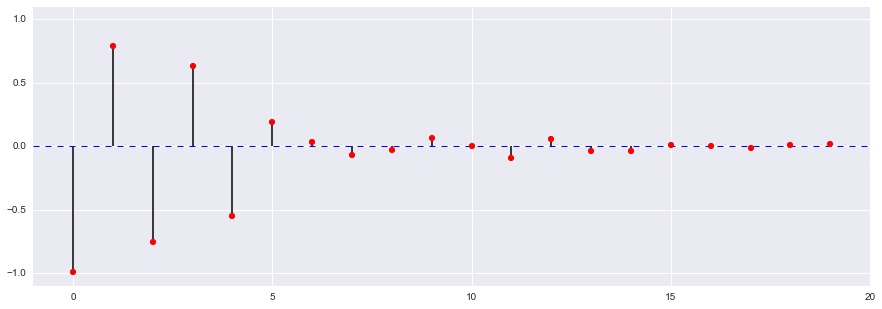

In [11]:
f,ax = pl.subplots(1,1,figsize = [15,5])
ax.axhline(ls = '--',lw = 1)
ax.plot(cff,'ro')
ax.vlines(range(20),[0],cff,lw=1.5)
ax.set_xlim([-1,20])
ax.set_ylim([-1.1,1.1])

[ 3526.35869964  6261.00818574  5666.02379958 ...,  1800.15583015
  1679.38177089  1527.29603255]
Periodogram PSD estimate
    Data length is 1249792
    PSD length is 624897
    Sampling 2000
    freq resolution 0.00160026628431
    datatype is real
    sides is onesided
    scal_by_freq is False



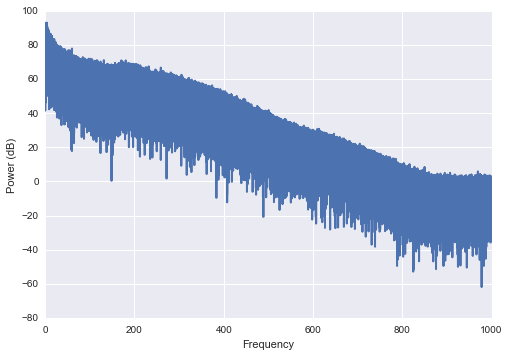

In [17]:
y = scsig.lfilter([1],cff[:6],csc.signal)
print y
pF = spc.Periodogram(y,csc.sampleFreq)
pF();
pF.plot()
print pF

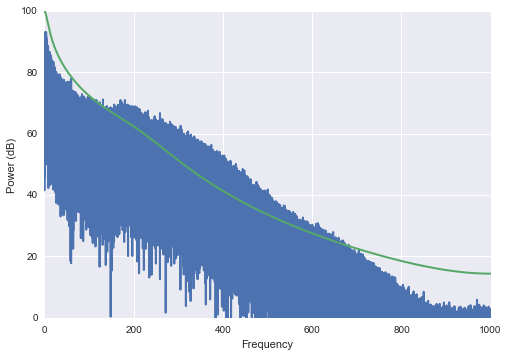

In [25]:
ar,ma, rho = spc.arma_estimate(csc.signal, 4,1,30)
psd = spc.arma2psd(A=ar, B=ma, rho=rho,NFFT=2000,T=624)
pl.axis([0, 1000, -0, 100])
#pl.xlabel('Frequency')
#pl.ylabel('power (dB)')
pF.plot()
pl.plot(10*np.log10(psd/max(psd))+100)

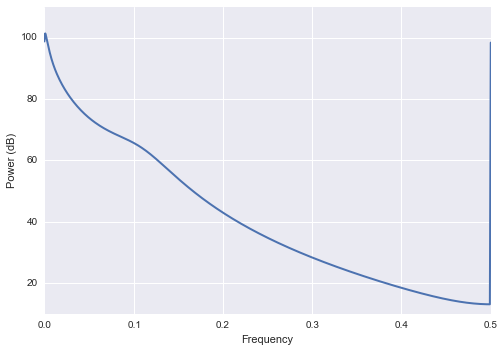

In [26]:
p41 = spc.parma(y, 4, 1, 30, NFFT=1000)
p41()
p102 = spc.parma(y, 10, 2, 30, NFFT=1000)
p102()
p.plot()

In [46]:
%matplotlib
pF.plot()
pl.plot(2000*np.array(p41.frequencies()),10*np.log10(p41.psd/max(p41.psd))+90)
pl.plot(2000*np.array(p102.frequencies()),10*np.log10(p102.psd/max(p102.psd))+90)

Using matplotlib backend: Qt4Agg


In [38]:
fft_smth = np.convolve(pF.psd,scsig.gaussian(700,200),'same')
pl.plot(pF.frequencies(),10*np.log10(fft_smth/max(fft_smth)))
pl.plot(p.frequencies,10*np.log10(p.psd/max(p.psd)))
#ax.fill_between(csc.freq,fft_smth,facecolor='yellow',alpha=0.4)


TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
ax3.set_xlim(50,250);
ax3.set_ylim(100,2e9);
ax3.set_xlabel('Frequency(Hz)')
ax3.set_ylabel('Power(a.u.)')
ax1.set_title('Ripple Duration')
ax1.set_xlabel('Time(ms)')
ax2.set_xlabel('Time(ms)')
ax2.set_xlim([0,5000])
ax2.set_title('IRI')
ax2.set_ylabel('')
ax1.set_ylabel('')

In [ ]:
for ax in [ax1,ax2,ax3]:
    ax.set_yticks([])
    ax.set_yticklabels('',visible = False)
    ax.xaxis.tick_bottom()
    ax.tick_params( direction='in')

In [ ]:
fig.tight_layout()
fig

In [ ]:
fig.savefig('/home/chenani/Pictures/BCCN_Report/fig2.pdf',format='pdf')

In [58]:
csc.duration()/1e3

624.896

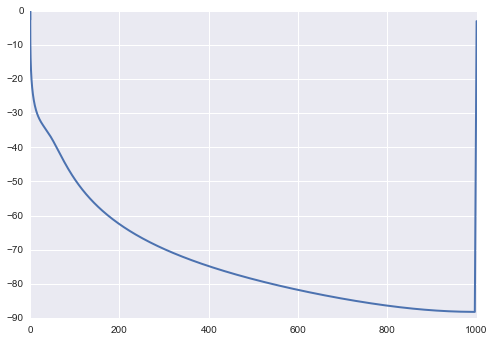

In [43]:
pl.plot(freqz,10*np.log10(p.psd/max(p.psd)))

In [1]:
sigsamp = csc.signal[:160]
fig = pl.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(sigsamp, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(sigsamp, lags=40, ax=ax2)

NameError: name 'csc' is not defined

In [ ]:
arma_mod20 = sm.tsa.ARMA(sigsamp, (3,2)).fit()
print arma_mod20.params
print arma_mod20.aic, arma_mod20.bic, arma_mod20.hqic
sm.stats.durbin_watson(arma_mod20.resid)

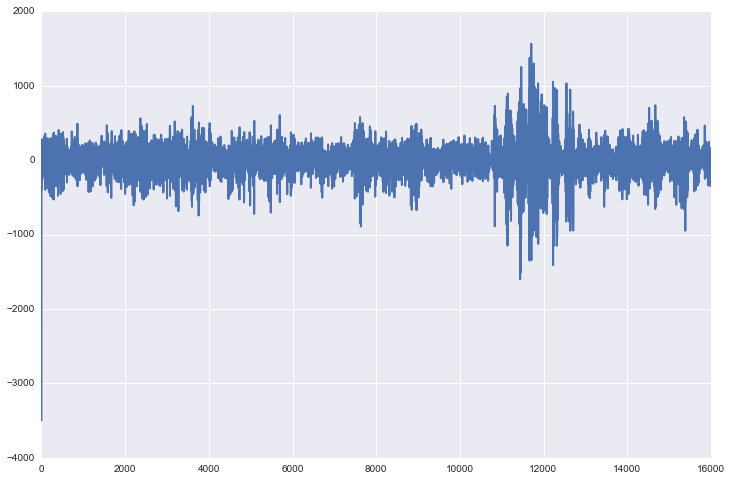

In [51]:
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(111)
ax.plot(arma_mod20.resid)

In [52]:
resid = arma_mod20.resid
scipy.stats.normaltest(resid)

(4077.4604267691507, 0.0)

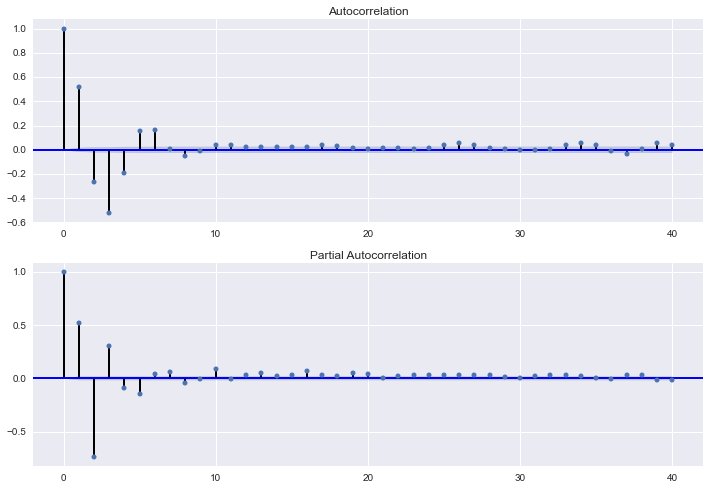

In [53]:
fig = pl.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid.squeeze(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid, lags=40, ax=ax2)

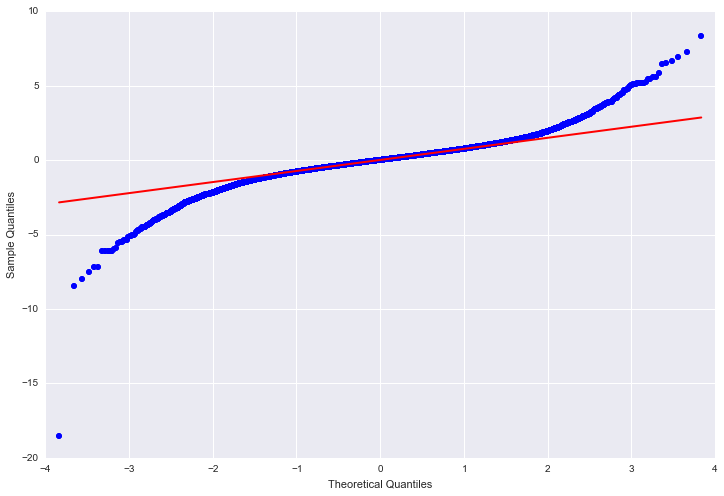

In [54]:
from statsmodels.graphics.api import qqplot
fig = pl.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)

In [62]:
%matplotlib
sigPSD = spc.Periodogram(arma_mod20.resid,csc.sampleFreq)
sigPSD()
sigPSD.plot()

Using matplotlib backend: Qt4Agg
